# Classification for the Spotify dataset
In the following, we will perform classification for the given dataset. Goal is _create a model classificator for labelling tracks by `genre`_.  
We will perform 3 attempts for this classification:
- multiclass classification with n_class = n_genra;
- multiclass classification with n_class < n_genra, and in particular we want to regroup consider some sort of 'basic' genra criterion. It has been considered the following classification: https://en.wikipedia.org/wiki/List_of_music_genres_and_styles;
- binary classification, not musical tracks vs musical tracks. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Evaluation metrics
Importing the metrics for evaluating performances.  
Here reporting some formulas in order to recap everything:  
$$Acc = \frac{TP + TN}{TP + TN + FP + FN} $$  
The F1 score can be interpreted as a harmonic mean (harmonic mean is the reciprocal of the aritmetic mean of the reciprocals. It is sometimes appropriate for situations when the average rate is desired) of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is F1 = 2 * (precision * recall) / (precision + recall):

$$F1_{\text{score}} = \frac{2TP}{2TP + FN + FP} $$  
$$Recall = \frac{TP}{TP + FN} $$

In [3]:
#Importing the performance metrics
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall

In [4]:
# importing datasets - one will be used for training, one for testing.
df_original_copy_training = pd.read_csv("dataset (missing + split)/train.csv", skipinitialspace=True)
df_train = pd.read_csv("dataset (missing + split)/train.csv", skipinitialspace=True) #this will be modified

df_test = pd.read_csv("dataset (missing + split)/test.csv", skipinitialspace=True)

# Data preparation: transformation and preprocessing
This has to be done on both training set and test set. 

### Data transformation

In [5]:
#Changing udm to duration_ms and features_duration_ms from ms to min - train
df_train['duration_ms'] *= 1/6e4
#Changing udm to duration_ms and features_duration_ms from ms to min - test
df_test['duration_ms'] *= 1/6e4
#Setting popularity as a % - train
df_train['popularity'] /= 100
df_train.rename(columns = {'duration_ms':'duration_min'}, inplace = True)
df_train.rename(columns = {'popularity':'popularity_percent'}, inplace = True)
#Setting popularity as a % - test
df_test['popularity'] /= 100
df_test.rename(columns = {'duration_ms':'duration_min'}, inplace = True)
df_test.rename(columns = {'popularity':'popularity_percent'}, inplace = True)

### Filling of NaN values

In [6]:
#Dealing with mode attribute missing values - train
#Computing p0 and p1 and filling missing values of mode attribute by sampling

p0=df_train['mode'].value_counts()[0]/(len(df_train)-df_train['mode'].isnull().sum())
p1=df_train['mode'].value_counts()[1]/(len(df_train)-df_train['mode'].isnull().sum())
list_of_nan_indexes_train=df_train[df_train['mode'].isnull()].index.tolist()
for i in list_of_nan_indexes_train:
    if np.random.random() < p1:
        df_train.loc[i,'mode'] = 1.0
    else:
        df_train.loc[i,'mode'] = 0.0
        
#Dealing with mode attribute missing values - test
#Computing p0 and p1 and filling missing values of mode attribute by sampling

p0=df_test['mode'].value_counts()[0]/(len(df_test)-df_test['mode'].isnull().sum())
p1=df_test['mode'].value_counts()[1]/(len(df_test)-df_test['mode'].isnull().sum())
list_of_nan_indexes_test=df_test[df_test['mode'].isnull()].index.tolist()
for i in list_of_nan_indexes_test:
    if np.random.random() < p1:
        df_test.loc[i,'mode'] = 1.0
    else:
        df_test.loc[i,'mode'] = 0.0

In [7]:
#Dealing with time_signature attribute missing values - train
#Computing the array containing the probabilities of every outcome for time_signature
outcomes_of_time_signature = len(df_train['time_signature'].value_counts())
p_array=np.array(df_train['time_signature'].value_counts().sort_index(ascending=True)/(len(df_train)-df_train['time_signature'].isnull().sum()))
#creating a dictionary containing the correspondance between value and sorted index
dict_ts = {0: 0.0, 1: 1.0, 2: 3.0, 3 : 4.0, 4 : 5.0}
list_of_nan_indexes_ts=df_train[df_train['time_signature'].isnull()].index.tolist()
from scipy.stats import multinomial 
#please forgive the dunb programming here, no real deal of time, only ~3000 points to be evaluated
for i in list_of_nan_indexes_ts:
    tmp = multinomial.rvs(1, p_array, size=1, random_state=None)
    array_tmp=np.where(tmp[0][:]==1)
    index=array_tmp[0][0] #implement a dict for the substitution
    df_train.loc[i,'time_signature'] = dict_ts[index]
    
#Dealing with time_signature attribute missing values - test
#Computing the array containing the probabilities of every outcome for time_signature
outcomes_of_time_signature = len(df_test['time_signature'].value_counts())
p_array=np.array(df_test['time_signature'].value_counts().sort_index(ascending=True)/(len(df_test)-df_test['time_signature'].isnull().sum()))
#creating a dictionary containing the correspondance between value and sorted index
dict_ts = {0: 0.0, 1: 1.0, 2: 3.0, 3 : 4.0, 4 : 5.0}
list_of_nan_indexes_ts=df_test[df_test['time_signature'].isnull()].index.tolist()
from scipy.stats import multinomial 
#please forgive the dunb programming here, no real deal of time, only ~3000 points to be evaluated
for i in list_of_nan_indexes_ts:
    tmp = multinomial.rvs(1, p_array, size=1, random_state=None)
    array_tmp=np.where(tmp[0][:]==1)
    index=array_tmp[0][0] #implement a dict for the substitution
    df_test.loc[i,'time_signature'] = dict_ts[index]

In [8]:
df_train['genre'].value_counts()

genre
j-dance          750
iranian          750
brazil           750
chicago-house    750
forro            750
idm              750
indian           750
study            750
disney           750
afrobeat         750
mandopop         750
techno           750
sleep            750
spanish          750
j-idol           750
industrial       750
happy            750
bluegrass        750
black-metal      750
breakbeat        750
Name: count, dtype: int64

In [9]:
df_test['genre'].value_counts()

genre
industrial       250
breakbeat        250
happy            250
afrobeat         250
study            250
black-metal      250
sleep            250
bluegrass        250
techno           250
brazil           250
j-dance          250
chicago-house    250
disney           250
iranian          250
mandopop         250
idm              250
spanish          250
j-idol           250
indian           250
forro            250
Name: count, dtype: int64

Pay attention, in train and test sets, genra does not have same order, it is necessary to use a dictionary map for BOTH. 

### Outlier criteria
For now, we do not consider any point as outlier because none of them miss the classification label and considering that this time one of our tasks is to distinguish between musical genra and not-musical genra. 

### Eliminating redundant features

In [10]:
df_train.dtypes

name                      object
duration_min             float64
explicit                    bool
popularity_percent       float64
artists                   object
album_name                object
danceability             float64
energy                   float64
key                        int64
loudness                 float64
mode                     float64
speechiness              float64
acousticness             float64
instrumentalness         float64
liveness                 float64
valence                  float64
tempo                    float64
features_duration_ms       int64
time_signature           float64
n_beats                  float64
n_bars                   float64
popularity_confidence    float64
processing               float64
genre                     object
dtype: object

In [11]:
column2drop = ['features_duration_ms', 'popularity_confidence', 'processing', 'name', 'artists','album_name'] #cols that gives max complexity
df_train.drop(column2drop, axis=1, inplace=True)
df_test.drop(column2drop, axis=1, inplace=True)

In [12]:
#Saving a variable containing all non-classification attributes
attributes = [col for col in df_train.columns if col != 'genre']

### Encoding `str` values - creating the various `genre` maps
- first map: 20 classes, one for every genre;
- second map: regrouping per macro genre with the following labels:  

| Label | Macro genre | `genre` list |
| ----------- | ----------- | -----------------------------------------------|
| 0 | Electronic | `breakbeat`, `chicago house`, `techno`, `afrobeat`, `idm` |
| 1 | Asian |`indian`|
| 2 | Pop| `mandopop`,`j-idol`,`happy`,`disney`,`j-dance`|
| 3 | Latin | `forro`,`brazil`,`spanish`|
| 4 | Country | `bluegrass`|
| 5 | Metal | `black metal`|
| 6 | Iranian | `iranian`|
| 7 | Others | `sleep`, `study`|

In [13]:
#Creating genre map I -> mapping every genre into an int value in order to have correlation values. 
genre_map={"j-dance":0,"iranian":1,"brazil":2,"chicago-house":3,"forro":4,"idm":5,"indian":6,"study":7,"disney":8,"afrobeat":9,"mandopop":10,"techno":11,"sleep":12,"spanish":13,"j-idol":14,"industrial":15,"happy":16,"bluegrass":17,"black-metal":18,"breakbeat":19}
#Creating genre map II -> mapping in macro-categories as described above
macrogenre_map={"j-dance":2,"iranian":6,"brazil":3,"chicago-house":0,"forro":3,"idm":0,"indian":1,"study":7,"disney":2,"afrobeat":0,"mandopop":2,"techno":0,"sleep":7,"spanish":3,"j-idol":2,"industrial":0,"happy":2,"bluegrass":4,"black-metal":5,"breakbeat":0}

NB: here _partitioning_ is not necessary because both train and test sets are already equally partitioned (so,holdout is not performed).

## First `genre` map - all genra in a different category

In [14]:
df_train.replace({'genre':genre_map})

,duration_min,explicit,popularity_percent,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,n_beats,n_bars,genre
0,4.029333,False,0.46,0.690,0.513,5,-12.529,1.0,0.0975,0.302000,0.536000,0.2810,0.6350,142.221,4.0,567.0,141.0,0
1,7.400000,False,0.00,0.069,0.196,1,-24.801,0.0,0.0805,0.283000,0.934000,0.3600,0.0336,75.596,4.0,617.0,155.0,1
2,5.558433,False,0.03,0.363,0.854,2,-7.445,1.0,0.0397,0.000089,0.800000,0.2620,0.4890,116.628,4.0,652.0,162.0,18
3,4.496667,False,0.23,0.523,0.585,5,-5.607,1.0,0.0765,0.066400,0.001270,0.1170,0.3850,140.880,4.0,619.0,155.0,17
4,5.127517,False,0.25,0.643,0.687,7,-11.340,1.0,0.0539,0.000576,0.096900,0.2990,0.6370,143.956,4.0,733.0,183.0,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,7.200433,False,0.00,0.554,0.657,1,-14.232,1.0,0.0558,0.016000,0.615000,0.1320,0.0335,117.319,4.0,837.0,212.0,5
14996,3.045767,False,0.44,0.103,0.860,1,-19.627,1.0,0.0595,0.548000,0.940000,0.1230,0.0016,92.323,3.0,277.0,92.0,12
14997,6.668183,False,0.43,0.799,0.535,1,-9.103,0.0,0.0594,0.001830,0.857000,0.0713,0.0708,126.000,4.0,837.0,209.0,11
14998,3.287500,False,0.37,0.511,0.970,5,-2.299,1.0,0.0531,0.000337,0.000014,0.4020,0.2700,160.044,4.0,513.0,130.0,19


### Encoding the bool attribute `explicit`

In [15]:
from sklearn.preprocessing import LabelEncoder

In [16]:
#just a trial, encoding the bool attribute `explicit`
# label encoding explicit feature
le = LabelEncoder()
df_train['explicit'] = le.fit_transform(df_train['explicit'])
df_test['explicit'] = le.fit_transform(df_test['explicit'])

In [17]:
y_train = df_train.replace({'genre':genre_map})['genre']
y_test = df_test.replace({'genre':genre_map})['genre']

X_train = np.array(df_train.replace({'genre':genre_map})[attributes])
X_test = np.array(df_test.replace({'genre':genre_map})[attributes])

In [18]:
X_train

array([[4.02933333e+00, 0.00000000e+00, 4.60000000e-01, ...,
        4.00000000e+00, 5.67000000e+02, 1.41000000e+02],
       [7.40000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        4.00000000e+00, 6.17000000e+02, 1.55000000e+02],
       [5.55843333e+00, 0.00000000e+00, 3.00000000e-02, ...,
        4.00000000e+00, 6.52000000e+02, 1.62000000e+02],
       ...,
       [6.66818333e+00, 0.00000000e+00, 4.30000000e-01, ...,
        4.00000000e+00, 8.37000000e+02, 2.09000000e+02],
       [3.28750000e+00, 0.00000000e+00, 3.70000000e-01, ...,
        4.00000000e+00, 5.13000000e+02, 1.30000000e+02],
       [3.30681667e+00, 0.00000000e+00, 3.60000000e-01, ...,
        4.00000000e+00, 2.86000000e+02, 7.20000000e+01]])

In [19]:
print(y_train)

0         0
1         1
2        18
3        17
4        16
         ..
14995     5
14996    12
14997    11
14998    19
14999     6
Name: genre, Length: 15000, dtype: int64


In [20]:
print(X_train)

[[4.02933333e+00 0.00000000e+00 4.60000000e-01 ... 4.00000000e+00
  5.67000000e+02 1.41000000e+02]
 [7.40000000e+00 0.00000000e+00 0.00000000e+00 ... 4.00000000e+00
  6.17000000e+02 1.55000000e+02]
 [5.55843333e+00 0.00000000e+00 3.00000000e-02 ... 4.00000000e+00
  6.52000000e+02 1.62000000e+02]
 ...
 [6.66818333e+00 0.00000000e+00 4.30000000e-01 ... 4.00000000e+00
  8.37000000e+02 2.09000000e+02]
 [3.28750000e+00 0.00000000e+00 3.70000000e-01 ... 4.00000000e+00
  5.13000000e+02 1.30000000e+02]
 [3.30681667e+00 0.00000000e+00 3.60000000e-01 ... 4.00000000e+00
  2.86000000e+02 7.20000000e+01]]


# Decision tree

In [21]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

#class sklearn.tree.DecisionTreeClassifier(*, criterion='gini', splitter='best', 
#max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
#max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, 
#class_weight=None, ccp_alpha=0.0)[source]

For now, we work only on _training test set_, in order to tune properly the parameters of the tree.  
After that, the test set will be used for computing the performance metrics. 

In [35]:
# Training a not-tuned tree, computing its performance metrics for doing a post-tuning comparison
dt = DecisionTreeClassifier()

In [36]:
%%time
dt.fit(X_train, y_train)

CPU times: user 205 ms, sys: 1.07 ms, total: 206 ms
Wall time: 205 ms


DecisionTreeClassifier()

In [37]:
dt.max_features_

17

In [38]:
y_train_pred = dt.predict(X_train)

In [39]:
y_train


0         0
1         1
2        18
3        17
4        16
         ..
14995     5
14996    12
14997    11
14998    19
14999     6
Name: genre, Length: 15000, dtype: int64

In [40]:
y_train_pred

array([ 0,  1, 18, ..., 11, 19,  6])

In [41]:
print('Train Accuracy %s' % accuracy_score(y_train, y_train_pred))
print('Train F1-score %s' % f1_score(y_train, y_train_pred, average=None))

Train Accuracy 1.0
Train F1-score [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [29]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       750
           1       1.00      1.00      1.00       750
           2       1.00      1.00      1.00       750
           3       1.00      1.00      1.00       750
           4       1.00      1.00      1.00       750
           5       1.00      1.00      1.00       750
           6       1.00      1.00      1.00       750
           7       1.00      1.00      1.00       750
           8       1.00      1.00      1.00       750
           9       1.00      1.00      1.00       750
          10       1.00      1.00      1.00       750
          11       1.00      1.00      1.00       750
          12       1.00      1.00      1.00       750
          13       1.00      1.00      1.00       750
          14       1.00      1.00      1.00       750
          15       1.00      1.00      1.00       750
          16       1.00      1.00      1.00       750
          17       1.00    

Okay, something seems wrong... let's keep going and try to understand what happened. 

In [49]:
print('Train Accuracy, no cross validation: %s' % accuracy_score(y_train, y_train_pred))
print('Train Accuracy, cross validation with 5 layers: %s' % cross_val_score(dt, X_train, y_train, cv=5, scoring='accuracy'))

Train Accuracy, no cross validation: 1.0
Train Accuracy, cross validation with 5 layers: [0.43533333 0.427      0.432      0.43033333 0.41833333]


#### What is happening:
It is evident the _overfitting_. The tree is computed considering the whole train test, being the tree overfitted, it gives perfect behaviour. When only a part of the training is used and the rest has to be predicted, the performances drastically worsen, because the model is adapted only to the training specific instances. 

In [30]:
zipped = zip(attributes, dt.feature_importances_)
zipped = sorted(zipped, key=lambda x: x[1], reverse=True)
for col, imp in zipped:
    print(col, imp)

popularity_percent 0.14031927738114514
danceability 0.09667375054361055
duration_min 0.09598123461097471
acousticness 0.09597478784962127
loudness 0.08435541813145274
valence 0.07701052091876108
speechiness 0.06791166844013082
tempo 0.06534132829604349
instrumentalness 0.06363914102968331
energy 0.06251299354157593
liveness 0.04693705622203728
n_beats 0.03149802109349989
n_bars 0.02781846618829398
key 0.02622710527777561
mode 0.00806064428182524
explicit 0.005085645615409365
time_signature 0.004652940578159697


Overfitting issue, seems like we have "perfect" performances.

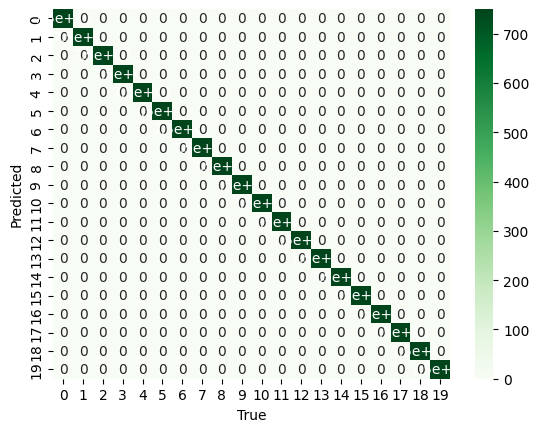

In [31]:
cf = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cf, annot=True, cmap="Greens")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

In [32]:
plt.figure(figsize=(20, 4), dpi=300)
plot_tree(dt, feature_names=attributes, filled=True)
plt.show()

KeyboardInterrupt: 

### Parameter tuning - I map
#### Randomized Search
See: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
Here the difference between this an `GridSearchCV()`:   
"_In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. The number of parameter settings that are tried is given by $n_{iter}$._"

In [33]:
from sklearn.model_selection import cross_val_score
# For metric choice with cross_val_score see: https://scikit-learn.org/0.15/modules/model_evaluation.html
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

In [34]:
scores = cross_val_score(dt, X_train, y_train, cv=5)
print(scores)

[0.43866667 0.42733333 0.43       0.432      0.423     ]


Before exploring a randomized search, we want to have an idea of what kind of values are reasonable for the most interesting parameters of the tree. 

Train Accuracy for max_depth=None :1.0
Train Accuracy for max_depth=50 :1.0
Train Accuracy for max_depth=51 :1.0
Train Accuracy for max_depth=52 :1.0
Train Accuracy for max_depth=53 :1.0
Train Accuracy for max_depth=54 :1.0
Train Accuracy for max_depth=55 :1.0
Train Accuracy for max_depth=56 :1.0
Train Accuracy for max_depth=57 :1.0
Train Accuracy for max_depth=58 :1.0
Train Accuracy for max_depth=59 :1.0
Train Accuracy for max_depth=60 :1.0
Train Accuracy for max_depth=61 :1.0
Train Accuracy for max_depth=62 :1.0
Train Accuracy for max_depth=63 :1.0
Train Accuracy for max_depth=64 :1.0
Train Accuracy for max_depth=65 :1.0
Train Accuracy for max_depth=66 :1.0
Train Accuracy for max_depth=67 :1.0
Train Accuracy for max_depth=68 :1.0
Train Accuracy for max_depth=69 :1.0
Train Accuracy for max_depth=70 :1.0
Train Accuracy for max_depth=71 :1.0
Train Accuracy for max_depth=72 :1.0
Train Accuracy for max_depth=73 :1.0
Train Accuracy for max_depth=74 :1.0
Train Accuracy for max_depth=75 :1.0

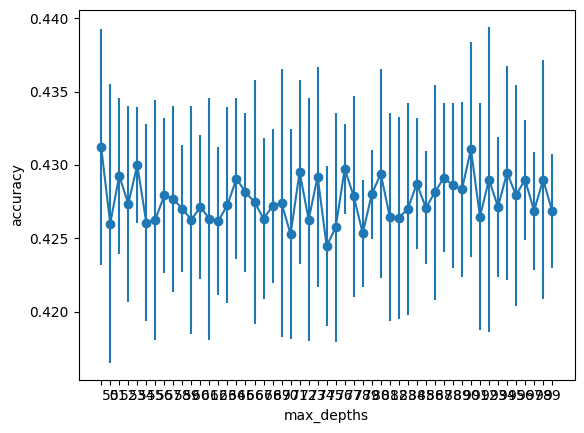

In [68]:
# considering max_depth
max_depths = [None] + list(np.arange(50, 100))
avg_scores = list()
std_scores = list()

for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth)
    scores = cross_val_score(dt, X_train, y_train, cv=5,scoring='accuracy')
    print(f'Train Accuracy for max_depth={max_depth} :{accuracy_score(y_train, y_train_pred)}')
    avg_scores.append(np.mean(scores))
    std_scores.append(np.std(scores))

plt.errorbar(range(len(max_depths)), y=avg_scores, yerr=std_scores, marker='o')
plt.xticks(range(len(max_depths)), max_depths)
plt.xlabel("max_depths")
plt.ylabel("accuracy")
plt.show()

In [ ]:
%%time
param_list = {
    'max_depth': [None] + list(np.arange(2, 20)),
    'min_samples_split': [2, 5, 10, 20, 30, 50, 100],
    'min_samples_leaf': [1, 5, 10, 20, 30, 50, 100],
    'criterion': ['gini', 'entropy']
}

#param_distributions : dict or list of dicts
#Dictionary with parameters names (str) as keys and distributions or 
#lists of parameters to try. Distributions must provide a rvs method 
#for sampling (such as those from scipy.stats.distributions). 
#If a list is given, it is sampled uniformly. If a list of dicts is given,
#first a dict is sampled uniformly, and then a parameter is sampled using that dict as above.

clf = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1)

random_search = RandomizedSearchCV(
    DecisionTreeClassifier(),
    param_distributions=param_list,
    cv=RepeatedStratifiedKFold(random_state=0),
    n_jobs=-1,
    refit=True,
    n_iter=200,
    #verbose=2
)

random_search.fit(X_train, y_train)
clf = random_search.best_estimator_